# Compare Seasonal Climatology from Xarray and CDAT

[Jiwoo Lee](https://github.com/lee1043/) (LLNL), March 2021

In this document, seasonal climatology fields calculated using [Xarray](xarray.pydata.org/) and [CDAT](https://cdat.llnl.gov/) are compared for checking consistency.

Useful resources:
- [Xarray instrcution from NCI data training](https://nci-data-training.readthedocs.io/en/latest/_notebook/climate/1_01_Xarray_access_CMIP5.html)
- [Xarray example: Calculating Seasonal Averages from Time Series of Monthly Means](http://xarray.pydata.org/en/stable/examples/monthly-means.html)

Testing Environment:
```
conda create -y -n cdat_v8.2.1 -c conda-forge -c cdat/label/v8.2.1 cdat "libnetcdf=*=mpi_openmpi_*" "mesalib=17.3.9" "python=3.7"
conda activate cdat_v8.2.1
conda install -c conda-forge xarray 
conda install -c conda-forge netcdf4 
```

## Example input data

In [1]:
input_file = "demo_data/CMIP5_demo_data/ts_Amon_ACCESS1-0_historical_r1i1p1_185001-200512.nc"

## Xarray

In [2]:
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

### Load data

In [3]:
%%time
f = xr.open_dataset(input_file, decode_times=True)
d = f.ts

CPU times: user 263 ms, sys: 6.41 ms, total: 269 ms
Wall time: 268 ms


In [4]:
d

<xarray.DataArray 'ts' (time: 1872, lat: 145, lon: 192)>
[52116480 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2005-12-16T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:     surface_temperature
    long_name:         Surface Temperature
    comment:           ""skin"" temperature (i.e., SST for open ocean)
    units:             K
    cell_methods:      time: mean
    cell_measures:     area: areacella
    history:           2012-01-17T03:16:09Z altered by CMOR: replaced missing...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

### Calculating Seasonal Averages from Timeseries of Monthly Means

Adapted from example at http://xarray.pydata.org/en/stable/examples/monthly-means.html

In [5]:
def season_mean(ds, calendar='standard'):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby('time.season').sum(dim='time')

In [6]:
%%time

d = d[2:-1]  # Exclude first Jan, Feb and last Dec
d_season_mean = season_mean(d) - 273.15

CPU times: user 588 ms, sys: 477 ms, total: 1.06 s
Wall time: 1.07 s


### Quick plot to show the results

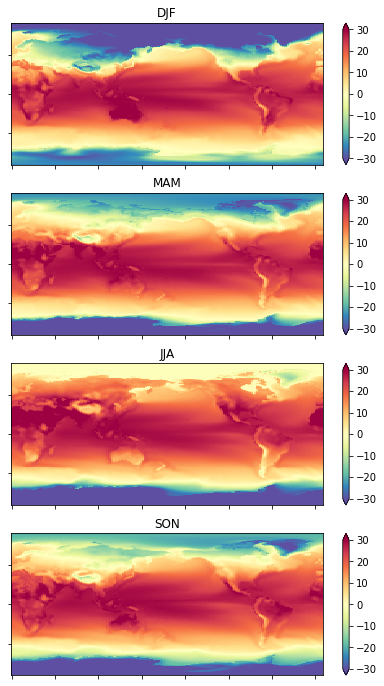

In [7]:
notnull = pd.notnull(d[0])

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(7,12))
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    d_season_mean.sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i], vmin=-30, vmax=30, cmap='Spectral_r',
        add_colorbar=True, extend='both')
    axes[i].set_title(season)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

## CDAT

### Load data

In [8]:
import cdms2
import cdutil

In [9]:
%%time

f2 = cdms2.open(input_file)
d2 = f2('ts')

CPU times: user 282 ms, sys: 261 ms, total: 543 ms
Wall time: 546 ms


In [10]:
d2

ts
masked_array(
  data=[[[252.7021 , 252.7021 , 252.7021 , ..., 252.7021 , 252.7021 ,
          252.7021 ],
         [254.13623, 254.11409, 254.07724, ..., 254.17943, 254.17729,
          254.15617],
         [255.36798, 255.28668, 255.19191, ..., 255.5753 , 255.5035 ,
          255.4374 ],
         ...,
         [234.86441, 234.88246, 234.93478, ..., 234.78558, 234.81828,
          234.83775],
         [234.44913, 234.4642 , 234.47993, ..., 234.42441, 234.44061,
          234.44269],
         [234.548  , 234.548  , 234.548  , ..., 234.548  , 234.548  ,
          234.548  ]],

        [[238.10487, 238.10487, 238.10487, ..., 238.10487, 238.10487,
          238.10487],
         [241.04808, 240.99707, 240.92943, ..., 241.20515, 241.16115,
          241.11426],
         [242.43816, 242.2475 , 242.06088, ..., 242.94102, 242.79178,
          242.61745],
         ...,
         [235.20607, 235.24445, 235.29167, ..., 235.13371, 235.15982,
          235.16357],
         [236.14331, 236.14923, 2

In [11]:
d2.shape

(1872, 145, 192)

### Calculate Seasonal Climatology

In [12]:
%%time

d2 = d2(time=slice(2,-1))  # Exclude first Jan, Feb and last Dec

d2_djf = cdutil.DJF.climatology(d2)(squeeze=1) - 273.15
d2_mam = cdutil.MAM.climatology(d2)(squeeze=1) - 273.15
d2_jja = cdutil.JJA.climatology(d2)(squeeze=1) - 273.15
d2_son = cdutil.SON.climatology(d2)(squeeze=1) - 273.15

CPU times: user 3.01 s, sys: 313 ms, total: 3.33 s
Wall time: 3.34 s


### Convert data type for quick plotting

Convert array type from CDAT transient variable to Xarray data array

In [13]:
lat = d2_djf.getLatitude()
lon = d2_djf.getLongitude()

In [14]:
d2_djf_xr = xr.DataArray(d2_djf, coords=[list(lat), list(lon)], dims=["lat", "lon"], name=d2.id)
d2_mam_xr = xr.DataArray(d2_mam, coords=[list(lat), list(lon)], dims=["lat", "lon"], name=d2.id)
d2_jja_xr = xr.DataArray(d2_jja, coords=[list(lat), list(lon)], dims=["lat", "lon"], name=d2.id)
d2_son_xr = xr.DataArray(d2_son, coords=[list(lat), list(lon)], dims=["lat", "lon"], name=d2.id)

In [15]:
d2_season = {}
d2_season['DJF'] = d2_djf_xr
d2_season['MAM'] = d2_mam_xr
d2_season['JJA'] = d2_jja_xr
d2_season['SON'] = d2_son_xr

### Quick plot to show the results

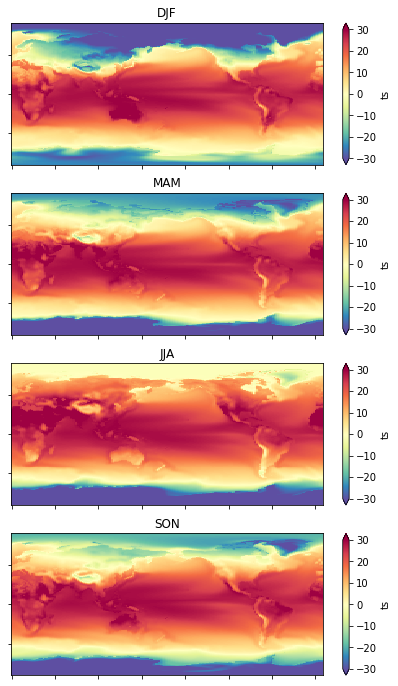

In [16]:
notnull = pd.notnull(d[0])

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(7,12))
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    d2_season[season].where(notnull).plot.pcolormesh(
        ax=axes[i], vmin=-30, vmax=30, cmap='Spectral_r',
        add_colorbar=True, extend='both')
    axes[i].set_title(season)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

## Check Difference between Xarray and CDAT

Text(0.5, 1.02, 'Seasonal Surface Air Temperature')

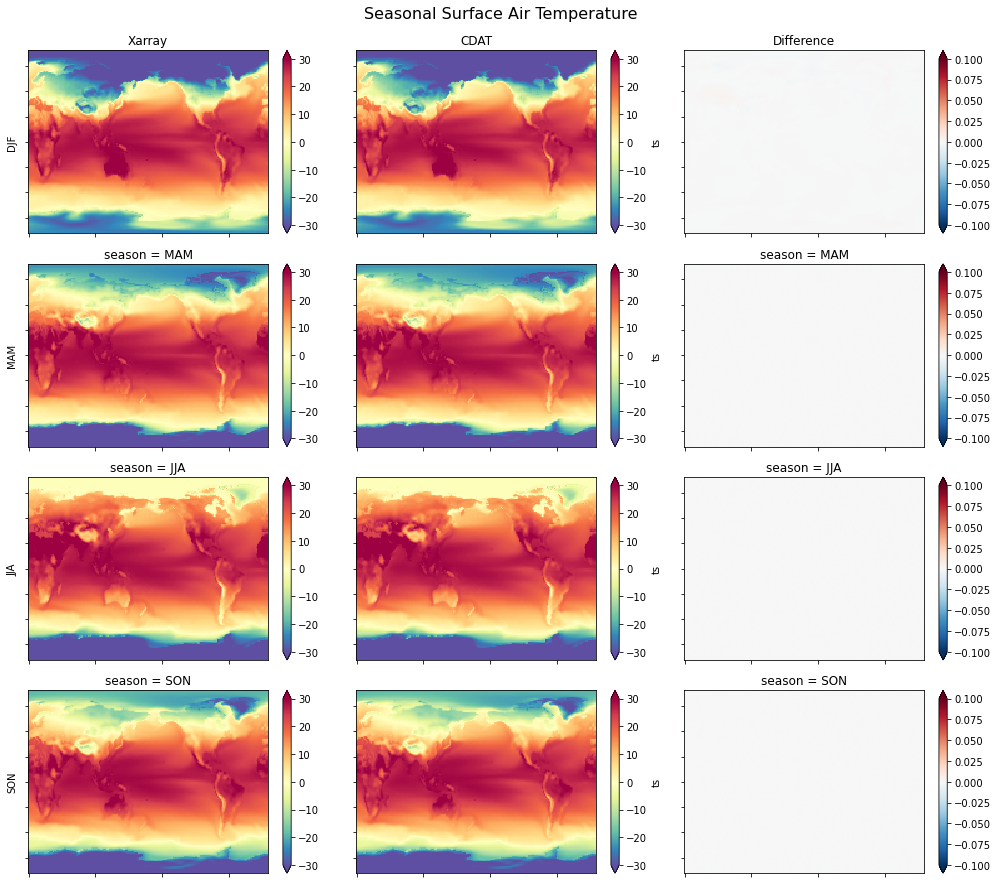

In [17]:
# Quick plot to show the results
notnull = pd.notnull(d[0])

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14,12))
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    # Xarray
    d_season_mean.sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 0], vmin=-30, vmax=30, cmap='Spectral_r',
        add_colorbar=True, extend='both')

    # CDAT
    d2_season[season].where(notnull).plot.pcolormesh(
        ax=axes[i, 1], vmin=-30, vmax=30, cmap='Spectral_r',
        add_colorbar=True, extend='both')

    # CDAT - Xarray
    (d2_season[season]-d_season_mean.sel(season=season)).where(notnull).plot.pcolormesh(
        ax=axes[i, 2], vmin=-0.1, vmax=.1, cmap='RdBu_r',
        add_colorbar=True, extend='both')

    axes[i, 0].set_ylabel(season)
    axes[i, 1].set_ylabel('')
    axes[i, 2].set_ylabel('')

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')

axes[0, 0].set_title('Xarray')
axes[0, 1].set_title('CDAT')
axes[0, 2].set_title('Difference')

plt.tight_layout()

fig.suptitle('Seasonal Surface Air Temperature', fontsize=16, y=1.02)